2025-08-16 10:22:13.663106: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-16 10:22:13.698810: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-16 10:22:13.698852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-16 10:22:13.700005: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-16 10:22:13.706506: I tensorflow/core/platform/cpu_feature_guar

Processing patch 1/49


2025-08-16 10:22:18.025549: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


Processing patch 2/49
Processing patch 3/49
Processing patch 4/49
Processing patch 5/49
Processing patch 6/49
Processing patch 7/49
Processing patch 8/49
Processing patch 9/49
Processing patch 10/49
Processing patch 11/49
Processing patch 12/49
Processing patch 13/49
Processing patch 14/49
Processing patch 15/49
Processing patch 16/49
Processing patch 17/49
Processing patch 18/49
Processing patch 19/49
Processing patch 20/49
Processing patch 21/49
Processing patch 22/49
Processing patch 23/49
Processing patch 24/49
Processing patch 25/49
Processing patch 26/49
Processing patch 27/49
Processing patch 28/49
Processing patch 29/49
Processing patch 30/49
Processing patch 31/49
Processing patch 32/49
Processing patch 33/49
Processing patch 34/49
Processing patch 35/49
Processing patch 36/49
Processing patch 37/49
Processing patch 38/49
Processing patch 39/49
Processing patch 40/49
Processing patch 41/49
Processing patch 42/49
Processing patch 43/49
Processing patch 44/49
Processing patch 45

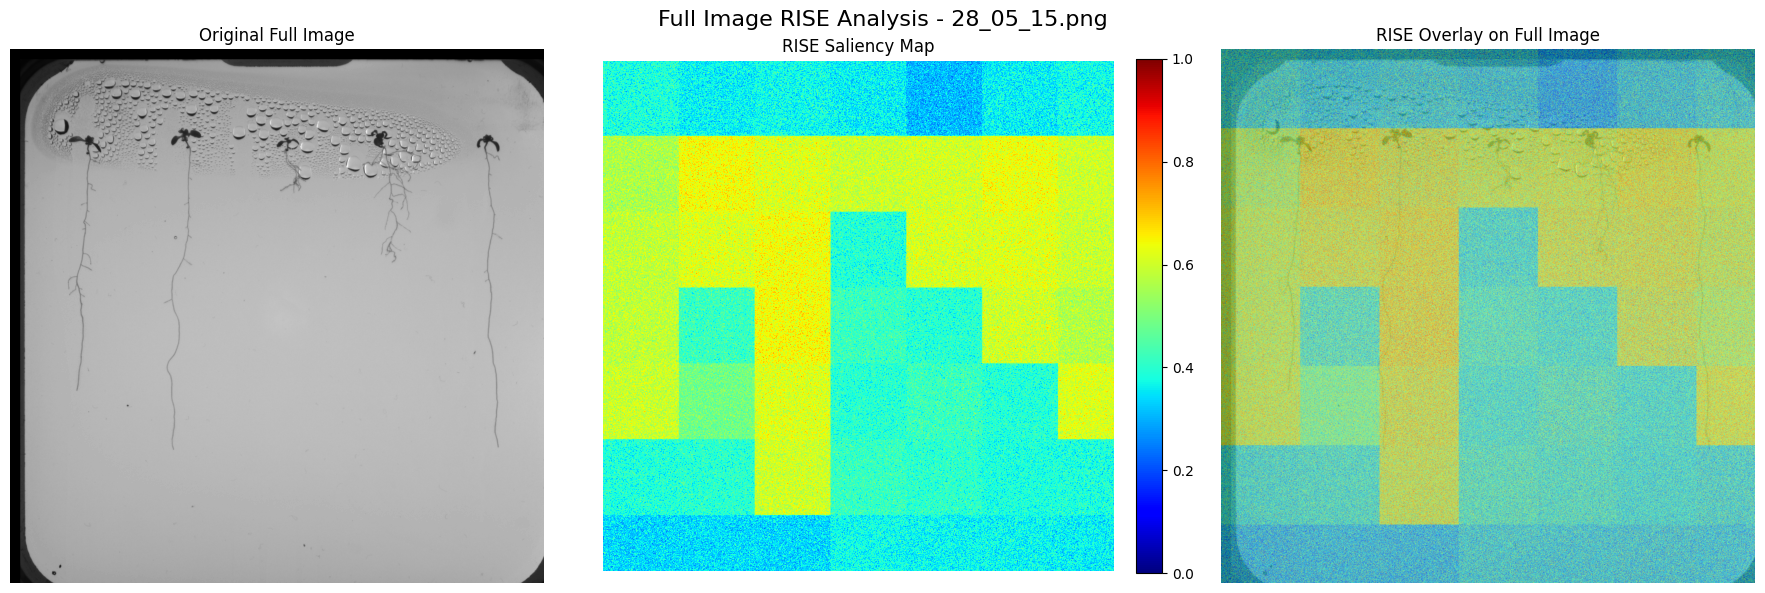

Processing completed.


In [1]:
import cv2
import numpy as np
import pandas as pd
from patchify import patchify, unpatchify
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os

from preprocess import crop, padder, crop_to_coordinates
from helpers import f1

def generate_rise_masks(input_shape, n_masks=50, p1=0.5):
    """Generate random binary masks for RISE"""
    masks = []
    for _ in range(n_masks):
        mask = np.random.binomial(1, p1, size=input_shape[:2])
        masks.append(mask)
    return np.array(masks)

def apply_mask(image, mask):
    """Apply binary mask to grayscale image"""
    # For grayscale image, just multiply directly
    if len(image.shape) == 3 and image.shape[2] == 1:
        masked_image = image.copy()
        masked_image[:, :, 0] = masked_image[:, :, 0] * mask
    else:
        # Handle 2D grayscale
        masked_image = image * mask
    return masked_image

def get_rise_saliency(model, image, n_masks=50, p1=0.5):
    """Generate RISE saliency map for a single patch"""
    # Get baseline prediction
    image_batch = np.expand_dims(image, axis=0)
    baseline_pred = model.predict(image_batch, verbose=0)[0]
    
    # Generate random masks
    masks = generate_rise_masks(image.shape, n_masks, p1)
    
    # Initialize saliency map
    saliency_map = np.zeros(image.shape[:2])
    
    # Process each mask
    for mask in masks:
        # Apply mask to image
        masked_image = apply_mask(image, mask)
        masked_batch = np.expand_dims(masked_image, axis=0)
        
        # Get prediction for masked image
        masked_pred = model.predict(masked_batch, verbose=0)[0]
        
        # Calculate difference (you may want to use specific class probability)
        if len(baseline_pred.shape) > 0:
            # For classification, use max class or specific class
            pred_diff = np.max(baseline_pred) - np.max(masked_pred)
        else:
            pred_diff = baseline_pred - masked_pred
        
        # Accumulate weighted mask
        saliency_map += mask * pred_diff
    
    # Normalize
    saliency_map = saliency_map / n_masks
    if saliency_map.max() > saliency_map.min():
        saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
    
    return saliency_map

def overlay_saliency_on_image(img, saliency_map, alpha=0.7):
    """Overlay saliency map on grayscale image"""
    # Convert grayscale to RGB for visualization
    if len(img.shape) == 3 and img.shape[2] == 1:
        img_rgb = np.repeat(img, 3, axis=2)
    elif len(img.shape) == 2:
        img_rgb = np.stack([img, img, img], axis=2)
    else:
        img_rgb = img
    
    saliency_rgb = plt.cm.jet(saliency_map)[:, :, :3]
    overlay = saliency_rgb * alpha + img_rgb * (1 - alpha)
    return overlay

def pipeline(image_dir, kernel_size=5, patch_size=256, n_masks=50, p1=0.5):
    model_path = "vit_model.h5"
    model = load_model(model_path, custom_objects={"f1": f1})

    for file in os.listdir(image_dir):
        if file.endswith('28_05_15.png'):
            
            # Load and preprocess image
            img_path = os.path.join(image_dir, file)
            image = cv2.imread(img_path, 0)  # Keep as grayscale
            image_cropped, stats, centroids = crop(image, kernel_size=kernel_size)
            
            # Keep as grayscale and normalize
            image_np = image_cropped / 255.0
            
            # Add channel dimension if needed for your model
            if len(image_np.shape) == 2:
                image_np = np.expand_dims(image_np, axis=-1)  # Shape: (H, W, 1)

            # Pad and patchify
            image_padded = padder(image_np, patch_size=patch_size)
            
            # Adjust patchify for grayscale
            if len(image_padded.shape) == 3:
                patches = patchify(image_padded, (patch_size, patch_size, 1), step=patch_size)
            else:
                patches = patchify(image_padded, (patch_size, patch_size), step=patch_size)
                
            expected_shape = (image_padded.shape[0] // patch_size, image_padded.shape[1] // patch_size)
            
            # Reshape patches
            if len(image_padded.shape) == 3:
                patches = patches.reshape(-1, patch_size, patch_size, 1)
            else:
                patches = patches.reshape(-1, patch_size, patch_size)

            # Process all patches and collect saliency maps
            saliency_patches = []
            overlay_patches = []
            
            for i, patch in enumerate(patches):
                print(f"Processing patch {i+1}/{len(patches)}")
                
                # Apply RISE to this individual patch
                saliency_map = get_rise_saliency(model, patch, n_masks=n_masks, p1=p1)
                overlay_patch = overlay_saliency_on_image(patch, saliency_map)
                
                saliency_patches.append(saliency_map)
                overlay_patches.append(overlay_patch)
            
            # Reshape patches back to grid format
            if len(image_padded.shape) == 3:
                patches_grid = np.array(patches).reshape(
                    expected_shape[0], expected_shape[1], 
                    patch_size, patch_size, 1
                )
            else:
                patches_grid = np.array(patches).reshape(
                    expected_shape[0], expected_shape[1], 
                    patch_size, patch_size
                )
            
            saliency_patches_grid = np.array(saliency_patches).reshape(
                expected_shape[0], expected_shape[1], 
                patch_size, patch_size
            )
            
            overlay_patches_grid = np.array(overlay_patches).reshape(
                expected_shape[0], expected_shape[1], 
                patch_size, patch_size, 3
            )
            
            # Manual reconstruction
            grid_h, grid_w = expected_shape[0], expected_shape[1]
            
            # Initialize full arrays
            full_image_reconstructed = np.zeros(image_padded.shape)
            full_saliency_reconstructed = np.zeros(image_padded.shape[:2])
            full_overlay_reconstructed = np.zeros((*image_padded.shape[:2], 3))
            
            # Manually place each patch back
            for i in range(grid_h):
                for j in range(grid_w):
                    y_start = i * patch_size
                    y_end = y_start + patch_size
                    x_start = j * patch_size
                    x_end = x_start + patch_size
                    
                    # Place patches back
                    full_image_reconstructed[y_start:y_end, x_start:x_end] = patches_grid[i, j]
                    full_saliency_reconstructed[y_start:y_end, x_start:x_end] = saliency_patches_grid[i, j]
                    full_overlay_reconstructed[y_start:y_end, x_start:x_end] = overlay_patches_grid[i, j]
            
            # Crop back to original size (remove padding)
            original_h, original_w = image_np.shape[:2]
            full_image_final = full_image_reconstructed[:original_h, :original_w]
            full_saliency_final = full_saliency_reconstructed[:original_h, :original_w]
            full_overlay_final = full_overlay_reconstructed[:original_h, :original_w]
            
            # Plot the results
            fig, axs = plt.subplots(1, 3, figsize=(18, 6))
            
            # Original full image
            if len(full_image_final.shape) == 3:
                axs[0].imshow(full_image_final.squeeze(), cmap='gray')
            else:
                axs[0].imshow(full_image_final, cmap='gray')
            axs[0].set_title("Original Full Image")
            axs[0].axis("off")
            
            # Saliency map
            im1 = axs[1].imshow(full_saliency_final, cmap='jet')
            axs[1].set_title("RISE Saliency Map")
            axs[1].axis("off")
            plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
            
            # Overlay
            axs[2].imshow(full_overlay_final)
            axs[2].set_title("RISE Overlay on Full Image")
            axs[2].axis("off")
            
            plt.suptitle(f"Full Image RISE Analysis - {file}", fontsize=16)
            plt.tight_layout()
            plt.show()

    print("Processing completed.")

# Example usage
if __name__ == "__main__":
    pipeline('data_v3_processed/xai', kernel_size=5, patch_size=256, n_masks=50, p1=0.8)